In [1]:
import numpy as np
import cv2
import pandas as pd

from harris import harris
from susan import susan
from matching import get_feature_hus

In [2]:
img1 = cv2.imread('images/sol.jpg',cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('images/sag.jpg',cv2.IMREAD_GRAYSCALE)

In [3]:
hu1 = get_feature_hus(img1)
hu2 = get_feature_hus(img2)

In [4]:
indices1 = []
indices2 = []
hu1s = []
hu2s = []
ratios = np.zeros(hu1['hus'].shape)

for i, hus1 in enumerate(hu1['hus']):
    distances = np.zeros(hu2['hus'].shape)
    for k, hus2 in enumerate(hu2['hus']):
        v = hus2 - hus1
        distances[k] = v[0,0]**2+v[1,0]**2+v[2,0]**2+v[3,0]**2+v[4,0]**2+v[5,0]**2+v[6,0]**2
    min_val = np.min(distances)
    if min_val >= 1:
        min_val = np.inf
    min_index = np.argmin(distances)
    #print(np.max(distances))
    #print(np.mean(distances))
    distances[min_index] = np.inf
    second_min_index = np.argmin(distances)
    second_min_val = np.min(distances)
    #print(min_val)
    #print(second_min_val)
    #print('---------------------')
    
    ratios[i] = np.sqrt(min_val / second_min_val)
    
    indices1.append([hu1['rows'][i], hu1['cols'][i]])
    indices2.append([hu2['rows'][min_index], hu2['cols'][min_index]])
    hu1s.append(hus1)
    hu2s.append(min_val)

In [5]:
df = pd.DataFrame({
    'index1': indices1,
    'index2': indices2,
    'hu1s': hu1s,
    'hu2s': hu2s,
    'ratios': ratios
})
print(df)

           index1      index2  \
0      [232, 881]   [530, 14]   
1      [233, 879]   [530, 14]   
2      [233, 880]   [527, 15]   
3      [233, 881]  [861, 147]   
4      [233, 882]  [861, 147]   
...           ...         ...   
3383  [1119, 731]  [567, 126]   
3384  [1119, 732]  [533, 269]   
3385  [1119, 733]  [1058, 16]   
3386  [1119, 734]  [532, 271]   
3387  [1119, 735]  [567, 126]   

                                                   hu1s      hu2s    ratios  
0     [[3.0497129906358085], [11.854436104145758], [...       inf       inf  
1     [[3.0496554133104845], [12.492425478003025], [...       inf       inf  
2     [[3.049662516289765], [12.328796137535516], [1...  0.490128  0.709334  
3     [[3.0498571062553506], [12.032624392355926], [...       inf       inf  
4     [[3.0502253090584004], [11.93540447146655], [1...       inf       inf  
...                                                 ...       ...       ...  
3383  [[2.740463146938454], [10.119519062387552], [1...  

In [6]:
rs = df['ratios'][df['ratios'] > -np.inf]
mean = np.mean(rs[rs < np.inf])
if np.isnan(mean):
    mean = 0
print(mean)
std = np.std(df['ratios'])
goods = df[df['ratios'] < 0.15 ]
first_ind = goods['index1']
second_ind = goods['index2']

0.8192861336267486


In [44]:
src_pts = []
dst_pts = []
for i in first_ind.index:
    src_pts.append(first_ind[i])
    dst_pts.append(second_ind[i])
srcs = np.array(src_pts)
dest = np.array(dst_pts)
# Calculate Homography
#homog, stat = cv2.findHomography(src_pts,dst_pts, cv2.RANSAC)
img = np.r_[img1,np.zeros((3, img1.shape[1]))]
print(img1.shape)
print(img2.shape)
new_image_size = (img1.shape[1] + img2.shape[1], img1.shape[0])
result = np.c_[img, img2[:,144:]]
print(result.shape)
H, masked = cv2.findHomography(srcs, dest, cv2.RANSAC, 5.0)

(1197, 1240)
(1200, 490)
(1200, 1586)


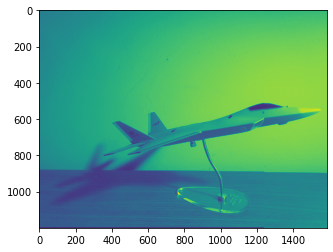

In [47]:
import matplotlib.pyplot as plt
res = cv2.warpPerspective(img1,H,((img1.shape[1] + img2.shape[1]), img2.shape[0])) #wraped image
res[0:img2.shape[0], 0:img2.shape[1]] = img2 #stitched image
plt.imshow(result)
plt.show()

# image yazioz

In [6]:
def get_one_image(img_list):
    max_width = 0
    total_height = 200  # padding
    for img in img_list:
        if img.shape[1] > max_width:
            max_width = img.shape[1]
        total_height += img.shape[0]

    # create a new array with a size large enough to contain all the images
    final_image = np.zeros((total_height, max_width), dtype=np.uint8)

    current_y = 0  # keep track of where your current image was last placed in the y coordinate
    for image in img_list:
        # add an image to the final array and increment the y coordinate
        image = np.hstack((image, np.zeros((image.shape[0], max_width - image.shape[1]))))
        final_image[current_y:current_y + image.shape[0], :] = image
        current_y += image.shape[0]
    return final_image

In [38]:
output = get_one_image([img1,img2])
offset = img1.shape[0]

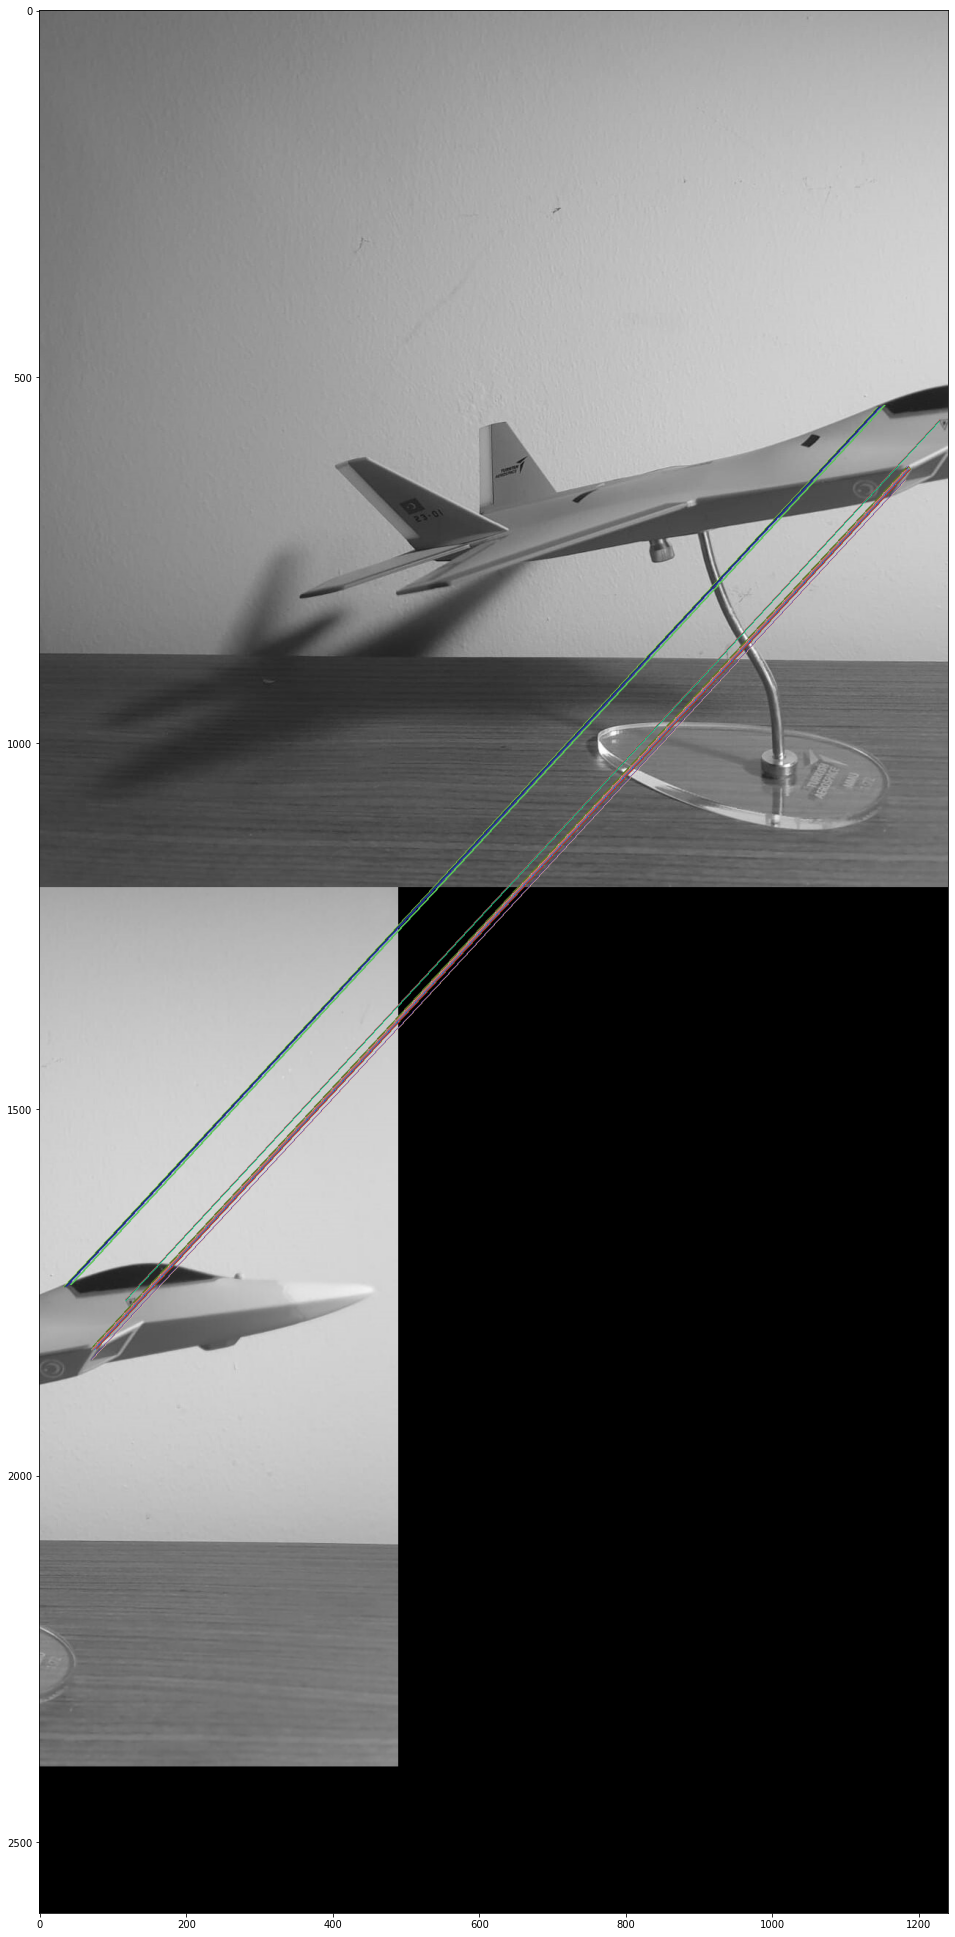

In [ ]:
import matplotlib.pyplot as plt
img = output[:,:]
img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
for i in first_ind.index:
    try:
        r = np.random.randint(255)
        g = np.random.randint(255)
        b = np.random.randint(255)
        img = cv2.line(img, (first_ind[i][1], first_ind[i][0]), (second_ind[i][1], second_ind[i][0] + offset), (r,g,b), 1)
    except KeyError:
        continue
#img = cv2.line(img, (0,0), (1600, 60), (0,0,0), 10)
plt.rcParams['figure.figsize'] = [70, 35]
plt.imshow(img)